In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.layers import Dense, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
from tensorflow.keras import backend as K
from transformers import ViTModel, ViTFeatureExtractor
import torch

# Focal Loss definition
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())  # Prevent log(0)
        cross_entropy = -y_true * K.log(y_pred)
        modulating_factor = K.pow(1. - y_pred, gamma)
        loss = alpha * modulating_factor * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# Paths to CSV file and images folder
csv_file = '/content/drive/MyDrive/Soft_Tissue/Final - Facial Profile Types.csv'
image_folder = '/content/drive/MyDrive/Soft_Tissue/cepha400'

# Load the CSV file and preprocess
df = pd.read_csv(csv_file)

# Remove "Concave - Convex" class
df = df[df['type'] != 'Concave - Convex']

# Function to get zero-padded image filenames
def get_image_path(image_id, folder):
    image_filename = f"{str(image_id).zfill(3)}.jpg"  # Zero-pad the image ID
    return os.path.join(folder, image_filename)

# Link image paths with tabular data and labels
images = []
labels = []
tabular_features = []

for index, row in df.iterrows():
    image_id = row['data']  # 'data' column
    label = row['type']     # 'type' column
    upper_lip = row['upper_lip']  # 'upper_lip' column
    lower_lip = row['lower_lip']  # 'lower_lip' column

    # Load image with zero-padded filename
    image_path = get_image_path(image_id, image_folder)
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
        labels.append(label)
        tabular_features.append([upper_lip, lower_lip])
    except FileNotFoundError:
        print(f"Image {image_path} not found.")
        continue

# Convert images and tabular features to NumPy arrays
images = np.array(images)
tabular_features = np.array(tabular_features)

# Encode tabular features using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
tabular_features_encoded = encoder.fit_transform(tabular_features)

# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

#
# First Split: 70% Train, 30% Temp
X_train_img, X_temp_img, X_train_tabular, X_temp_tabular, y_train, y_temp = train_test_split(
    images, tabular_features_encoded, labels_one_hot, test_size=0.3, random_state=42, stratify=labels_encoded
)

# Second Split: 15% Validation, 15% Test
X_val_img, X_test_img, X_val_tabular, X_test_tabular, y_val, y_test = train_test_split(
    X_temp_img, X_temp_tabular, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

# Load Vision Transformer model and extract features
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

def extract_vit_features(images):
    features = []
    for img in images:
        img_processed = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
        with torch.no_grad():
            outputs = vit_model(img_processed)
            features.append(outputs.last_hidden_state[:, 0, :].numpy())  # CLS token embedding
    return np.array(features).squeeze()

X_train_img_vit = extract_vit_features(X_train_img)
X_val_img_vit = extract_vit_features(X_val_img)
X_test_img_vit = extract_vit_features(X_test_img)

# Build the multimodal model
input_img = Input(shape=(X_train_img_vit.shape[1],), name="image_input")
input_tabular = Input(shape=(X_train_tabular.shape[1],), name="tabular_input")

# Tabular feature model
x_tabular = Dense(128, activation="relu")(input_tabular)

# Combine ViT and tabular features
combined = Concatenate()([input_img, x_tabular])
x = Dense(256, activation="relu")(combined)
x = Dropout(0.5)(x)
output = Dense(y_train.shape[1], activation="softmax")(x)

# Create the multimodal model
model = Model(inputs=[input_img, input_tabular], outputs=output)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, amsgrad=True)
model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    [X_train_img_vit, X_train_tabular], y_train,
    validation_data=([X_val_img_vit, X_val_tabular], y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate([X_val_img_vit, X_val_tabular], y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on the test set
y_pred = model.predict([X_test_img_vit, X_test_tabular])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Calculate F1 Scores
macro_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
weighted_f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"\nMacro-Average F1 Score: {macro_f1:.4f}")
print(f"Weighted-Average F1 Score: {weighted_f1:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.4986 - loss: 0.1548 - val_accuracy: 0.6000 - val_loss: 0.1127
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6443 - loss: 0.1097 - val_accuracy: 0.9333 - val_loss: 0.0915
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8100 - loss: 0.0824 - val_accuracy: 0.7667 - val_loss: 0.0731
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8377 - loss: 0.0715 - val_accuracy: 0.9333 - val_loss: 0.0560
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9431 - loss: 0.0512 - val_accuracy: 0.9333 - val_loss: 0.0426
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9598 - loss: 0.0370 - val_accuracy: 0.9333 - val_loss: 0.0314
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9379 - loss: 0.0369 - val_accuracy: 0.9333 - val_loss: 0.0224
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9727 - loss: 0.0202 - val_accuracy: 0.9333 - val_loss: 0.0176

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
import tensorflow as tf
import cv2

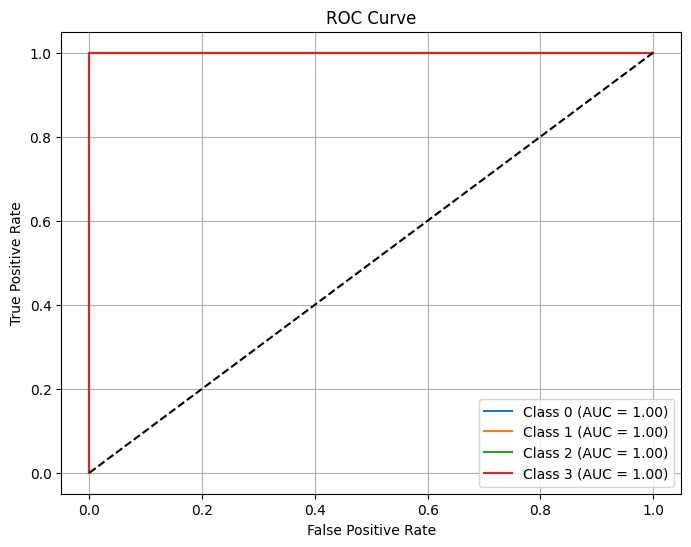

In [3]:
#  Compute ROC & AUC**
def plot_roc_auc(y_true, y_pred):
    plt.figure(figsize=(8, 6))

    for i in range(y_pred.shape[1]):  # Loop over classes
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Compute and Plot ROC-AUC
plot_roc_auc(y_test, y_pred)

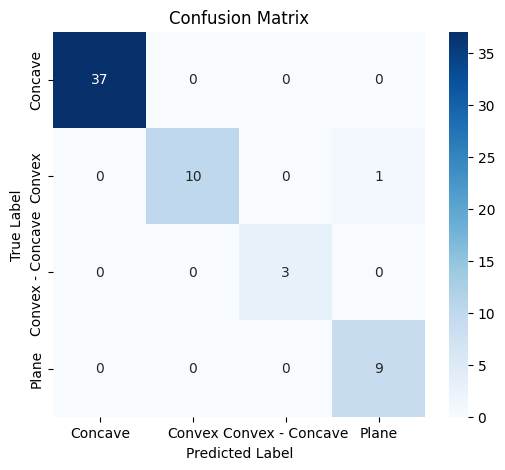

In [4]:
def plot_confusion_matrix(y_true, y_pred_classes, class_names):
    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_true_classes, y_pred_classes, class_names=label_encoder.classes_)
